<img width="100" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

Forest Emissions Tracking - Phase I
===================================

_by Joe Hamman and Jeremy Freeman (CarbonPlan)_

March 29, 2020

## Introduction
In general, greenhouse gasses (GHGs) arising from forest land use changes can be attributed to both natural factors (e.g. wildfire) and human activities (e.g. deforestation). Our approach is to build upon an existing body of research that has provided high-resolution satellite-based estimates of aboveground biomass (Spawn et al., 2020), forest cover change (Hansen et al., 2013), and change attribution (Curtis et al., 2018). While many of the necessary data products already exist, we can integrate, extend, or update these resources to provide global, current estimates that can be integrated with the other resources produced by the coalition.

Specifically, for any given spatial extent and time duration ($t1$ to $t2$), we can use three quantities — existing biomass, forest cover change, and change attribution — to estimate the effective GHG emissions from land use changes. The simplest estimate is:

$\Delta Biomass (t) = TotalBiomass (t) * \Delta ForestCover (\%)$

$Emissions (tCO_2) = \Delta Biomass (t) * 0.5 (tC/t) * 3.67 (tC02 / tC)$

where $\Delta ForestCover$ is the fraction of pixels within the given spatial extent that experienced a stand-replacement disturbance between $t1$ and $t2$. The $TotalBiomass$ is estimated as the aboveground biomass at time $t1$. This estimate can be further refined by attributing, for each pixel, the source of forest cover loss (e.g. wildfire, deforestation, etc.), and using those sources to express emissions fractionally and/or exclude certain categories from total estimates (e.g. rotational clear-cutting within tree plantations). Pixel-wise estimates can then be aggregated into province and country-wide estimates.

## Setup

To begin, we'll import a handful of Python libraries and set a few constants.

In [2]:
%matplotlib inline
import dask
import matplotlib.pyplot as plt
import geopandas
import intake
import xarray as xr
import rioxarray
import numpy as np
import seaborn as sns
from dask.distributed import Client
from shapely.geometry import mapping
from sklearn.metrics import mean_squared_error

from data import open_hansen_2018_tile

# TODO: switch to carbonplan style theme
plt.rcParams["font.family"] = "monospace"

TC02_PER_TC = 3.67
TC_PER_TBM = 0.5
SQM_PER_HA = 10000
ORNL_SCALING = 0.1

In [3]:
# start a local Dask cluster
# client = Client(n_workers=4)
# display(client)

Next we will open a handful of datasets that we'll use in our analysis. Note that these datasets are all included in an _Intake Catalog_ called `catalog.yaml`. Intake, along with a small helper script (`data.py`) will handle opening all of our data for us.

In [4]:
# data catalog
cat = intake.open_catalog('catalog.yaml')

The first dataset we will open is the Hansen et al (2018) forest cover change dataset. We also open auxillary datasets like above ground biomass (`abg`) and two partial estimates of emissions (`emissions_ha` and `emissions_px`) that are all available on the same 30x30m grid. All of this data is distributed in 10x10degree tiles so we define which tile we'll be looking at for this demonstration. We also define a smaller bounding box (`box`) that we will use for a few analyses later on.

In [5]:
# open a single 10x10degree tile of the Hansen 30x30m data
lat = '50N'
lon = '130W'
box = dict(lat=slice(41.5, 41.), lon=slice(-123, -122.5))

ds = open_hansen_2018_tile(lat, lon)
display(ds)

<xarray.Dataset>
Dimensions:        (band: 4, lat: 40000, lon: 40000)
Coordinates:
  * lat            (lat) float64 50.0 50.0 50.0 50.0 ... 40.0 40.0 40.0 40.0
  * lon            (lon) float64 -130.0 -130.0 -130.0 ... -120.0 -120.0 -120.0
  * band           (band) int64 1 2 3 4
Data variables:
    treecover2000  (lat, lon) float64 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    gain           (lat, lon) uint8 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    lossyear       (lat, lon) uint16 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    datamask       (lat, lon) uint8 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    first          (band, lat, lon) uint8 dask.array<chunksize=(4, 4000, 4000), meta=np.ndarray>
    last           (band, lat, lon) uint8 dask.array<chunksize=(4, 4000, 4000), meta=np.ndarray>
    agb            (lat, lon) int16 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    emissions_ha   (lat, lon) int16 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    emissions_px   (lat, lon) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>

Next, we open a few other datasets:

1. The Spawn and Gibbs (2020) Global Aboveground and Belowground Biomass Carbon Density Maps for the Year 2010: `ds_ornl`.
1. A shapefile including the each of the US states: `us_states`.
1. A data table of estimated state aggregated biomass for each US state: `df_fia_state`.
1. A data table of biomass for all the FIA plot locations in California: `df_ca_fia`.

In [6]:
# open some data for benchmarking

# ORNL biomass
ds_ornl = cat.ornl_biomass.to_dask() * ORNL_SCALING

# shapefile for US states
states = geopandas.read_file('/home/jovyan/.local/share/cartopy/shapefiles/natural_earth/cultural/ne_50m_admin_1_states_provinces_lakes.shp')
us_states = states.query("admin == 'United States of America'").set_index('iso_3166_2')
us_states.crs = "EPSG:4326"

# State-wide Biomass aggregation from FIA
df_fia_state = cat.fia_by_state.read()

# California Biomass by FIA plot
df_ca_fia = cat.fia_ca.read()

ValueError: group not found at path ''

In [ ]:
variables = ['treecover2000', 'lossyear', 'agb', 'emissions_ha']
titles = ['Tree Cover Fraction (year: 2000)\n(Hanson et al. 2013) ', 'Year of Tree Cover Loss\n(Hanson et al. 2013)', 'Aboveground Biomass\n(Zarin et al. 2016)', 'Emissions']
units = ['[%]', '[year]', '[t/Ha]', '[tC02/Ha]']

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(8, 8))

ds_plot = ds.sel(**box)

kwargs = {}
for i, var in enumerate(variables):
    ax = axes.flat[i]
    if i == 2:
        kwargs = dict(vmin=0, vmax=600, extend='max')
    if i == 3:
        kwargs = dict(vmin=0, vmax=1100, extend='max')
    if i == 1:
        kwargs = dict(vmin=2000, vmax=2018, levels=19)
    da = ds_plot[var]
    da.plot.imshow(ax=ax, add_labels=False, cbar_kwargs={'label': units[i]}, **kwargs)
    ax.set_title(titles[i])

fig.tight_layout()

The Hansen tree cover and loss data is compressed into a initial treecover field and a lossyear field. In the cell below, we unpack this data into a 3-dimensional mask of losses by year. This will come in handy when we start analyzing emissions by year. We add this new field (`d_treecover`) to our dataset.

In [7]:
# calculate d_treecover
years = xr.DataArray(range(2001, 2019), dims=('year', ), name='year')
loss_frac = []
for year in years:
    loss_frac.append(xr.where((ds['lossyear'] == year), ds['treecover2000'], 0))
ds['d_treecover'] = xr.concat(loss_frac, dim=years)
display(ds)

<xarray.Dataset>
Dimensions:        (band: 4, lat: 40000, lon: 40000, year: 18)
Coordinates:
  * lat            (lat) float64 50.0 50.0 50.0 50.0 ... 40.0 40.0 40.0 40.0
  * lon            (lon) float64 -130.0 -130.0 -130.0 ... -120.0 -120.0 -120.0
  * band           (band) int64 1 2 3 4
  * year           (year) int64 2001 2002 2003 2004 2005 ... 2015 2016 2017 2018
Data variables:
    treecover2000  (lat, lon) float64 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    gain           (lat, lon) uint8 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    lossyear       (lat, lon) uint16 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    datamask       (lat, lon) uint8 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    first          (band, lat, lon) uint8 dask.array<chunksize=(4, 4000, 4000), meta=np.ndarray>
    last           (band, lat, lon) uint8 dask.array<chunksize=(4, 4000, 4000), meta=np.ndarray>
    agb            (lat, lon) int16 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    emissions_ha   (lat, lon) int16 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    emissions_px   (lat, lon) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    d_treecover    (year, lat, lon) float64 dask.array<chunksize=(1, 4000, 4000), meta=np.ndarray>

We can now sum over all the years in our data to see the change in treecover for each pixel in our tile.

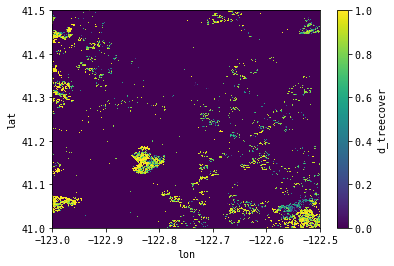

In [8]:
ds['d_treecover'].sum('year').sel(**box).plot()

### Emissions Calculation

As we discussed above, the equation to compute emissions from a change in above ground biomass is simply a conversion of lost biomass to an equivalent mass of C02. The function below represents how this is performed in our analysis.

In [9]:
def calc_emissions(ds):
    d_biomass = ds['agb'] * ds['d_treecover']
    emissions = d_biomass * TC_PER_TBM * TC02_PER_TC
    return emissions

In [10]:
ds['emissions'] = calc_emissions(ds)
display(ds['emissions'])

,Array,Chunk
Bytes,230.40 GB,128.00 MB
Shape,"(40000, 40000, 18)","(4000, 4000, 1)"
Count,15421 Tasks,1800 Chunks
Type,float64,numpy.ndarray


Now that we have calculated the emissions at each point in our tile, we can visualize the results. The maps below show emissions, by year, for each pixel in our tile.

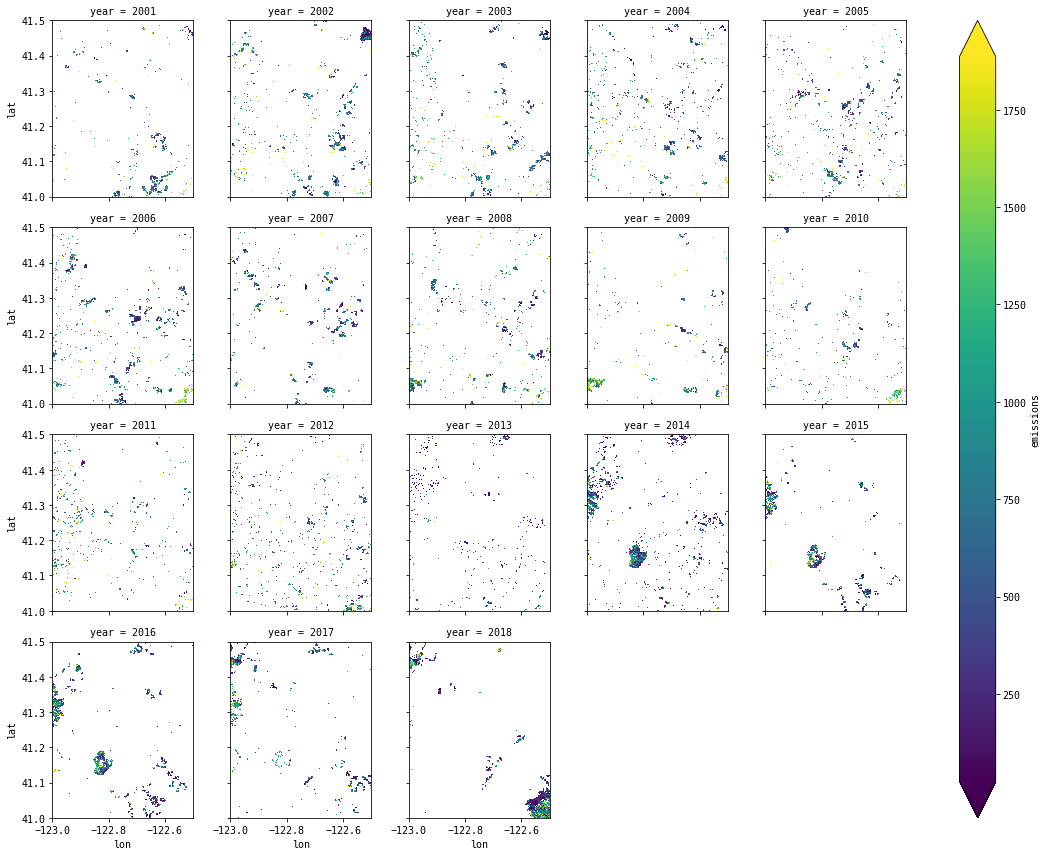

In [11]:
temp = ds['emissions'].sel(**box)
temp = temp.where(temp).persist()
fg = temp.plot(col='year', col_wrap=5, robust=True)

We can now sum over our tile to compute the emissions from this region by year. To do this, we first need to compute the per-pixel area to perform an accurate unit conversion.

In [12]:
def compute_grid_area(da):
    R = 6.371e6
    total_area = (4 * np.pi * R**2)
    dϕ = np.radians((da['lat'][1]-da['lat'][0]).values)
    dλ = np.radians((da['lon'][1]-da['lon'][0]).values)
    dA = R**2 * np.abs(dϕ * dλ) * np.cos(np.radians(da['lat']))
    areacella = dA * (0 * da + 1)
    
    return areacella / SQM_PER_HA

In [13]:
def scatter_style(ax, aspect=('equal', 'box')):
    '''helper function to style the next few scatter plots'''
    if aspect:
        ax.set_aspect(*aspect)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

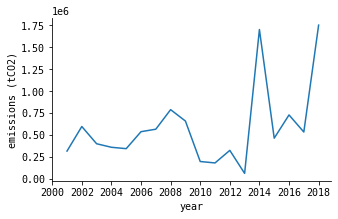

In [14]:
area = compute_grid_area(temp)

fig, ax = plt.subplots(figsize=(5, 3))
(temp * area).sum(('lat', 'lon')).plot(ax=ax)[0]
plt.ylabel('emissions (tCO2)')
plt.xticks(ticks=range(2000, 2020, 2))
scatter_style(ax, aspect=None)

## Comparison

We focus on comparative analysis on the biomass datasets used so far in this notebook. For the purposes of this demonstration we will take a look at a small tile, to qualatatively assess the Zarin and Spawn & Gibbs data.

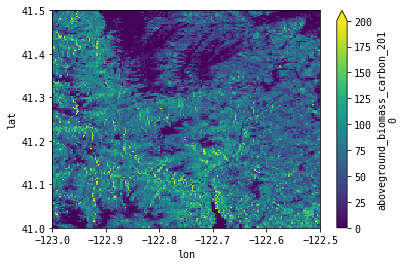

In [16]:
(ds_ornl['aboveground_biomass_carbon_2010']).sel(**box).plot(vmin=0, vmax=200)

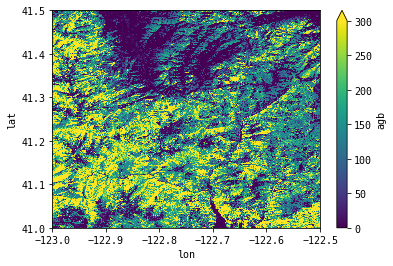

In [17]:
(ds['agb'] * TC_PER_TBM).sel(**box).plot(vmin=0, vmax=300)

## Ground Truthing


### Part 1. US State Aggregation
Our ground truthing has taken two initial forms. First we compare regional (state) aggregated biomass estimates from Spawn & Gibbs to FIA state aggregated data.

In [18]:
@dask.delayed
def calc_state_biomass(source, gdf):
    '''lazy helper function to compute aggregated biomass by shape'''
    import rioxarray
    # open the dataset inside the task
    obj = source.to_dask()['aboveground_biomass_carbon_2010'] * ORNL_SCALING
    obj.rio.set_spatial_dims('lon', 'lat')
    obj.rio.set_crs(4326)
    clipped = obj.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)
    cell_area = compute_grid_area(clipped)
    return (clipped * cell_area).sum().values.item() / 1e6 # Tg C

In [19]:
# aggregate the ORNL (Spawn and Gibbs) data by state.

from dask.diagnostics import ProgressBar

biomass = [calc_state_biomass(cat.ornl_biomass, us_states.iloc[[i]]) for i in range(len(us_states))]
with ProgressBar():
    us_states['biomass_computed'] = dask.compute(*biomass, scheduler='single-threaded')

# extract the FIA data and put it in our us_states dataframe
for st, val in (df_fia_state.values):
    us_states.loc[f'US-{st}', 'biomass_fia'] = val
us_states.head(n=2)

[########################################] | 100% Completed | 30min  0.1s


,featurecla,scalerank,adm1_code,diss_me,wikipedia,iso_a2,adm0_sr,name,name_alt,name_local,...,name_pt,name_ru,name_sv,name_tr,name_vi,name_zh,ne_id,geometry,biomass_computed,biomass_fia
iso_3166_2,,,,,,,,,,,,,,,,,,,,,
US-AK,Admin-1 scale rank,2,USA-3563,3563,http://en.wikipedia.org/wiki/Alaska,US,6,Alaska,AK|Alaska,None,...,Alasca,ÐÐ»ÑÑÐºÐ°,Alaska,Alaska,Alaska,é¿ææ¯å å·,1159308731,"MULTIPOLYGON (((-139.05652 60.00158, -139.0434...",1417.589333,477.0
US-AL,Admin-1 scale rank,2,USA-3541,3541,http://en.wikipedia.org/wiki/Alabama,US,5,Alabama,AL|Ala.,None,...,Alabama,ÐÐ»Ð°Ð±Ð°Ð¼Ð°,Alabama,Alabama,Alabama,äºæå·´é©¬å·,1159315233,"MULTIPOLYGON (((-87.48951 30.37768, -87.51325 ...",644.164948,464.0


Now that we've computed biomass estimates for each state, we can compare them to the FIA aggregated data.

Text(0.65, 0.02, 'rmse: 89.12')

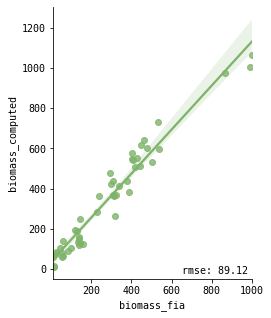

In [20]:
state_biomass = us_states[['biomass_fia', 'biomass_computed', 'geometry']].drop(labels='US-AK').dropna(axis=0)

f, ax = plt.subplots(figsize=(5, 5))
sns.regplot(x='biomass_fia', y='biomass_computed', data=state_biomass, color='#7EB36A', ax=ax)
scatter_style(ax)
skill = mean_squared_error(state_biomass['biomass_fia'], state_biomass['biomass_computed'], squared=False)
ax.text(0.65, 0.02, f'rmse: {skill:.2f}', transform=ax.transAxes)

In [21]:
# a few simple difference statistics
state_biomass['pdiff'] = ((state_biomass['biomass_computed'] - state_biomass['biomass_fia']) / state_biomass['biomass_fia']) * 100
state_biomass['adiff'] = state_biomass['biomass_computed'] - state_biomass['biomass_fia']

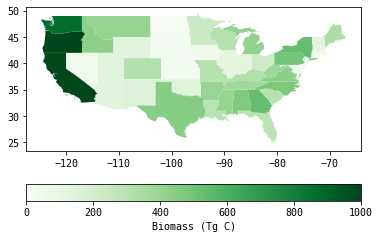

In [22]:
state_biomass.plot(
    column='biomass_fia',
    legend=True, vmin=0, vmax=1000, cmap='Greens',
    legend_kwds={'label': "Biomass (Tg C)", 'orientation': "horizontal"})

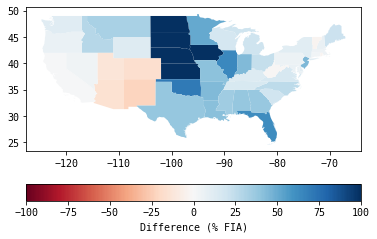

In [23]:
state_biomass.plot(
    column='pdiff',
    legend=True, vmin=-100, vmax=100, cmap='RdBu',
    legend_kwds={'label': "Difference (% FIA)", 'orientation': "horizontal"})

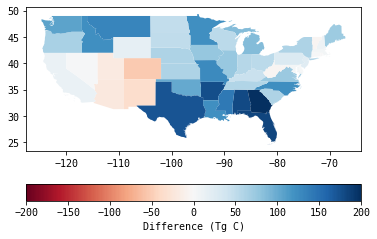

In [24]:
state_biomass.plot(
    column='adiff',
    legend=True, vmin=-200, vmax=200, cmap='RdBu',
    legend_kwds={'label': "Difference (Tg C)", 'orientation': "horizontal"})

### Part 2. FIA Plot Comparison

For the second form of ground truthing we compare biomass estimates to actual FIA plot data. We have extracted all FIA plot locations in the state of California (shown in figure below) and we compare those to Spawn and Gibbs data below.

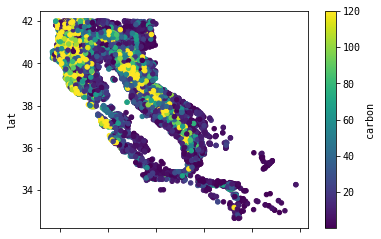

In [25]:
df_ca_fia.plot.scatter('lon', 'lat', c='carbon', cmap='viridis', vmax=120)

In [26]:
fia_da = df_ca_fia.to_xarray().rename({'index': 'plot'})[['lat', 'lon']]
da = ds_ornl['aboveground_biomass_carbon_2010'].sel(lat=fia_da.lat, lon=fia_da.lon, method='nearest', tolerance=1.).load()
df_ca_fia['ornl_biomass'] = da.to_series()
df_ca_fia.head()

,lat,lon,year,carbon,forested,ornl_biomass
0,41.668415,-123.223050,2001,1.048546,0.550953,26.3
1,38.490033,-122.362509,2003,43.988928,1.000000,13.2
2,40.710897,-121.429543,2002,8.255487,0.025933,5.7
3,40.750922,-121.582805,2002,27.205646,0.048196,42.6
4,37.246750,-118.126485,2005,1.589760,1.000000,0.6


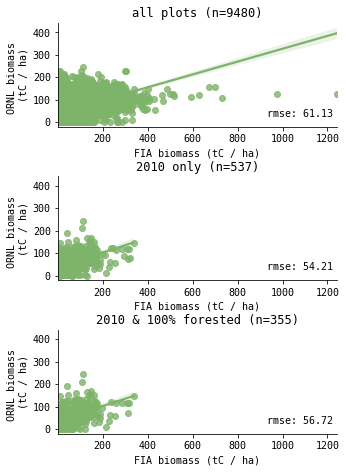

In [27]:
f, axes = plt.subplots(nrows=3, figsize=(5, 8), sharex=True, sharey=True)

sns.regplot(x='carbon', y='ornl_biomass', data=df_ca_fia, color='#7EB36A', ax=axes[0])
skill = mean_squared_error(df_ca_fia['carbon'], df_ca_fia['ornl_biomass'], squared=False)
axes[0].annotate(f'rmse: {skill:.2f}', xy=(0.15, 0.8), xycoords='data', xytext=(0.75, 0.1), textcoords='axes fraction')
axes[0].set_title(f'all plots (n={len(df_ca_fia)})')

df = df_ca_fia.query("year == 2010")
sns.regplot(x='carbon', y='ornl_biomass', data=df, color='#7EB36A', ax=axes[1])
skill = mean_squared_error(df['carbon'], df['ornl_biomass'], squared=False)
axes[1].annotate(f'rmse: {skill:.2f}', xy=(0.15, 0.8), xycoords='data', xytext=(0.75, 0.1), textcoords='axes fraction')
axes[1].set_title(f'2010 only (n={len(df)})')

df = df.query("forested > 0.99")
sns.regplot(x='carbon', y='ornl_biomass', data=df, color='#7EB36A', ax=axes[2])
skill = mean_squared_error(df['carbon'], df['ornl_biomass'], squared=False)
axes[2].annotate(f'rmse: {skill:.2f}', xy=(0.15, 0.8), xycoords='data', xytext=(0.75, 0.1), textcoords='axes fraction')
axes[2].set_title(f'2010 & 100% forested (n={len(df)})')

for ax in axes:
    plt.sca(ax)
    plt.ylabel('ORNL biomass \n(tC / ha)')
    plt.xlabel('FIA biomass (tC / ha)')
    scatter_style(ax)
fig.tight_layout()

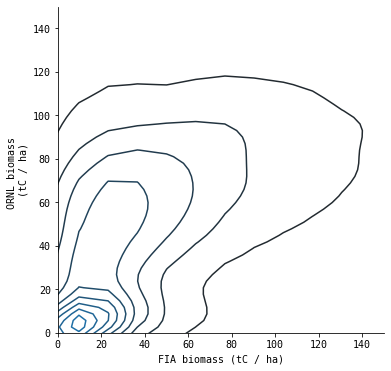

In [28]:
f, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(df_ca_fia.carbon, df_ca_fia.ornl_biomass, ax=ax, )

plt.ylabel('ORNL biomass \n(tC / ha)')
plt.xlabel('FIA biomass (tC / ha)')
plt.xlim(0, 150)
plt.ylim(0, 150)
scatter_style(ax)

## References:

- Curtis, P. G. et al. (2018) ‘Classifying drivers of global forest loss’, Science, 361(6407), pp. 1108–1111. doi: 10.1126/science.aau3445.
- Eidenshink, J. et al. (2007) ‘A Project for Monitoring Trends in Burn Severity’, Fire Ecology, 3(1), pp. 3–21. doi: 10.4996/fireecology.0301003.
- Hansen, M. C. et al. (2013) ‘High-resolution global maps of 21st-century forest cover change’, Science, 342(6160), pp. 850–853. doi: 10.1126/science.1244693.
- Hubau, W., et al. (2020) ‘Asynchronous carbon sink saturation in African and Amazonian tropical forests’, Nature, 80–87(2020). doi: 10.1038/s41586-020-2035-0
- Spawn, S. A. et al. (2020) ‘Harmonized global maps of above and belowground biomass carbon density in the year 2010’, Scientific Data. doi: 10.1038/s41597-020-0444-4.
- Zarin, D. J. et al. (2016) ‘Can carbon emissions from tropical deforestation drop by 50% in 5 years?’, Global Change Biology, pp. 1336–1347. doi: 10.1111/gcb.13153.